# Principal Component Analysis

Principal component analysis (PCA) is perhaps one of the most broadly use of unsupervised algorithms. PCA is fundamentally a dimensionality reduction algorithm, but it's also a very useful tool for visualization, noise filtering, feature extraction and engineering, and more. 

In this section we'll briefly discuss the concepts behind the PCA algorithm, as well as some of its applications. We begin with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Introducing Principal Component Analysis

PCA is a fast and flexible unsupervised method for dimensionality reduction. We can most easily visualize its behavior by looking at a two-dimensional dataset. Consider the following data:

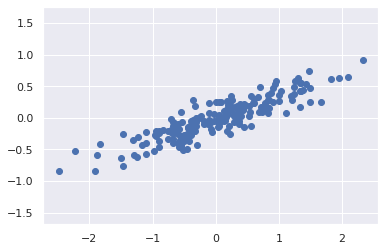

In [2]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

We can see that there is a nearly linear relationship between the x and y variables. A unsupervised learning problem is all about learning the relationship between the variables, similar to what we just did to this data by eye.

In PCA, this relationship is quantified by finding the list of the _principal axes_ in the data, and using them to describe the dataset. We can compute this using the `PCA` estimator as follows:

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

This fit learns some quantities from the data, most importantly the "components" and "explained variance":

In [4]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [5]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


We can better understand what these numbers mean by visualizing them as vectors over the input data. We will use the "components" to define the direction of the vector, and the "explained variance" to define its squared-length:

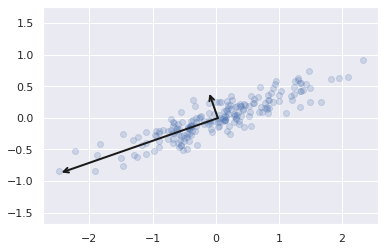

In [6]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0,
                    color='k')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

These vectors represent the _principal axes_ of the data, and the length of the vector if a measure of the variance of the data when projected onto that axis (thus, it indicates the "importance" of that axis in describing the data distribution). The projection of each data point onto the principal axes are the "principal components" of the data.

This transformation from data axes to principal axes is an _affine transformation_ (composed of a translation, rotation and uniform scaling).

## PCA as dimensionality reduction

Using PCA for dimensionality reduction involves zeroing out the smallest principal components, such that we achieve a lower-dimensional projection of the data that preserves most of data variance.

Let's take a look at an example of such dimensionality reduction transform:

In [7]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


We can see that the transformed data has been reduced to a single dimension. We can better understand the effect of this dimensionality reduction by performing the inverse transform and plotting it along with the original data:

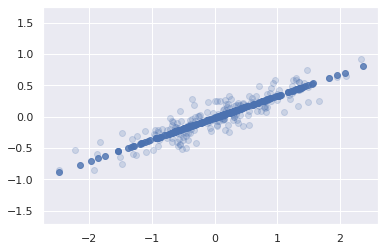

In [8]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], c='b', alpha=0.8)
plt.axis('equal');

We can see that the information along the least important principal axis was removed, leaving only the component with the highest variance. We can also observe that despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

## PCA for visualization: Hand-written digits

The usefulness of dimensionality reduction becomes much more apparent when looking at high-dimensional data. Let's see this in action using the digits data:

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The data consists of 8 $\times$ 8 pixel images, meaning that they are 64-dimensional. We can use PCA to project this data into a more manageable number of dimensions, such as two:

In [10]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


We can now plot the first two principal components of each point to gain some intuition into the relationships between the data:

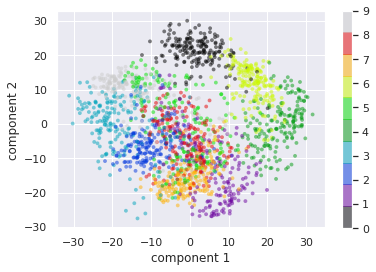

In [11]:
plt.scatter(projected[:, 0], projected[:, 1], s=plt.rcParams['lines.markersize'] ** 1.5,
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Essentially, this visualization represents the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions without any reference to the labels.

### What do the components mean

The meaning of the reduced dimensions can be understood in terms of combinations of basis vectors. Each image in the dataset is defined by a collection of 64 pixel values, which we call the vector $x$:

$$
x = [x_1, x_2, x_3, \dots , x_{64}] 
$$

One way to think about this is in terms of a pixel basis: to construct the image, we multiply each element of the vector by the pixel it represents, and then add it all together to build the image:

$$
\text{image}(x) = x_1 \cdot \text{(pixel 1)} + x_2 \cdot \text{(pixel 2)} + x_3 \cdot \text{(pixel 3)} + \dots + x_{64} \cdot \text{(pixel 64)}
$$

Reducing the dimension of this data can be imagined as zeroing out all but a few of these basis vectors. We could use, for example, only the first eight pixels to get an eight-dimensional representation of this data, but this would not be very representative of the whole image: we've thrown out nearly 90% of the pixels!

![Pixel Components](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.09-digits-pixel-components.png)

The figure above represents the process just described: the upper row shows the individual pixels, while the lower row shows the cumulative contribution of these pixels to the construction of the image. We can see that we are only able to construct a small portion of the whole original image. 

However, the pixel-wise representation is not the only choice of basis. We can also use other basis functions that contain some pre-defined contribution from each pixel, and write something like:

$$
\text{image}(x) = \rm{mean} + x_1 \cdot \text{(basis 1)} + x_2 \cdot \text{(basis 2)} + x_3 \cdot \text{(basis 3)} + \dots + x_{64} \cdot \text{(basis 64)}
$$

This way, PCA can be thought of as a process of choosing optimal basis functions, such that using just a few of them is enough to suitably reconstruct the bulk of the elements in the dataset. The principal components act as the low-dimensional representation of our data, and are nothing more than coefficients that multiply each of the elements in this series. 

![PCA Components](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.09-digits-pca-components.png)

We can see that unlike the pixel basis, the PCA basis allows us to recover much more of the input image with just a mean plus eight components. In this sense, PCA discovers a set of basis functions that are much more efficient than the native pixel-basis of the input data.

### Choosing the number of components

Estimating how many components are needed to describe the data plays a pivotal role of using PCA in practice. We can determine this by looking at the cumulative _explained variance ratio_ as a function of the number of components:

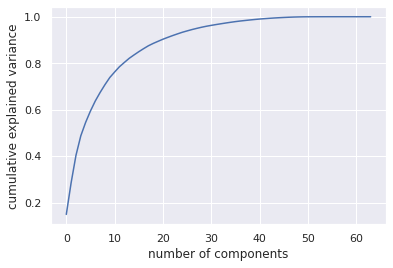

In [12]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total 64-dimensional variance in contained within the first $N$ components. We can see that the first 10 components contain about 75% of the variance, while we need around 50 components to describe close to 100% of the variance.

We can see that a two-dimensional projection loses a lot of information, and that we would need about 20 components to retain 90% of the variance. Analyzing this plot for high-dimensional datasets can help us understand the level of redundancy present in multiple observations.

## PCA as Noise Filtering

PCA can also be used for filtering noisy data. The idea is that any components with variance much larger than the effect of the noise should be relatively unaffected by such noise. 

Let's see how this works with the digits data. First let's take a look at the noise-free input data:

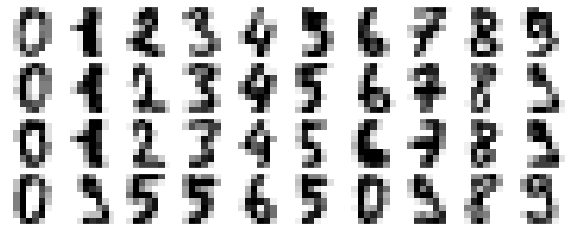

In [13]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

Now let's add some random noise to create a noisy dataset, and plot it:

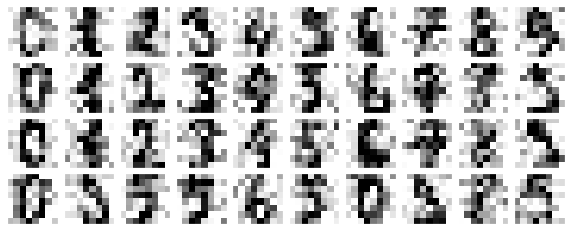

In [14]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

It is pretty evident that the images are noising, containing lots of spurious pixels. We'll now train a PCA on the noisy data, requesting a projection that retains 50% of the variance:

In [15]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

Now we can compute these 12 components, and then use the inverse transform to reconstruct the filtered digits:

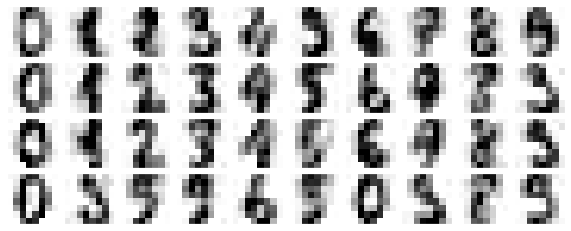

In [16]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

This signal preserving/noise filtering property makes PCA a very useful feature selection routine!

## Example: Eigenfaces

Let's take a look at using a PCA projection as a feature selector for facial recognition using the Labeled Faces in the Wild dataset:

In [17]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Because this is a relatively large dataset, we will use `svd_solver='randomized'`, which very efficiently (when compared to the standard solver) approximates the first $N$ principal components. We will take a look at the first 150 components:

In [18]:
pca = PCA(150, svd_solver='randomized')
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
    svd_solver='randomized', tol=0.0, whiten=False)

It can be interesting to visualize the images associated with the first several principal components (these components are technically known as "eigenvectors", so these types of images are often called "eigenfaces"):

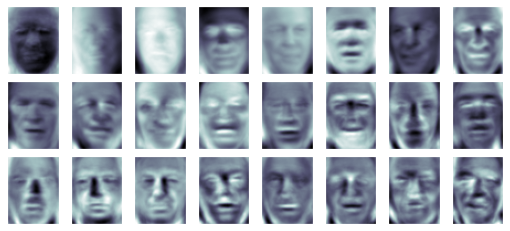

In [19]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

We can see that the first few eigenfaces seem to be associated with the angle of lightning on the face, and later principal vectors seem to be picking out features such as eyes, noses and lips. Let's examine how much of the data information the projection is preserving:

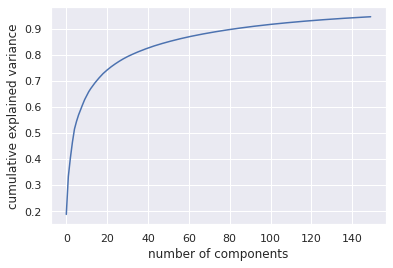

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We can see that these 150 components account for over 90% of the variance. We can get a more concrete sense what this number means by comparing the input images with the imaged reconstructed from these 150 components:

In [21]:
# Compute the components and projected faces
pca = PCA(150, svd_solver='randomized').fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

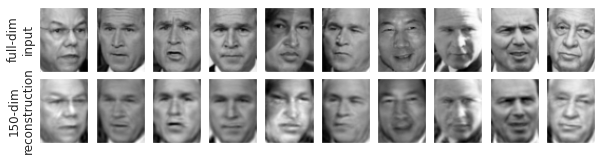

In [22]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

We can see the original input images on the top row, while the bottom row shows the reconstruction of such images using just 150 of the ~3000 initial features. We can see that even though the dimensionality of the data was reduces by nearly of factor of 20, the projected images contain enough information that we might, by eye, recognize the individuals in the images. This effectively means that a classification algorithm would need to be trained on 150-dimensional data rather than 3000-dimensional data, and could still produce very similar results on top of a much more efficient classification.